In [32]:
import os
import sys
import datacube
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from otps import TimePoint
from otps import predict_tide
from dateutil.relativedelta import relativedelta
from collections import Counter
import warnings

sys.path.append('../10_Scripts')
import SpatialTools, DEAPlotting

# Create datacube instance
dc = datacube.Datacube(app='Tidal geomedian filmstrips')
dc_upgrade = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')


def date_range(start_date, end_date, freq = '1YS'):
    
    '''
    Generates a dictionary of from-to date ranges based on a start and end date, and
    a temporal frequency (e.g. annually or six-monthly etc).
    
    Frequencies are based on Panda's date offset objects - see the following list:
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects.
    Options include annual ('1YS'), every 6 months ('6MS') etc.
    
    Outputs a dictionary with each time range named by its starting date.
    '''    

    # Convert to list of from-to dates. 
    from_dates = pd.date_range(start_date, end_date, freq=freq)[:-1].astype(str).values
    to_dates = pd.date_range(start_date, end_date, freq=freq)[1:].astype(str).values
    
    # Combine into a dictionary. Starting dates for each range are used to name output files.
    date_ranges = {a: (a, b) for (a, b) in np.dstack([from_dates, to_dates])[0]}
    
    return date_ranges


def mostcommon_utm(dc, product, query):    
    
    '''
    Takes a given query and returns the most common UTM zone for 
    observations returned for that spatial extent.
    
    '''
    
    # List of matching products
    matching_datasets = dc.find_datasets(product=product, **query)
    
    # Extract all CRSs
    crs_list = [str(i.crs) for i in matching_datasets]    
   
    # Identify most common CRS
    crs_counts = Counter(crs_list)    
    crs_mostcommon = crs_counts.most_common(1)[0][0]

    # Warn user if multiple CRSs are encountered
    if len(crs_counts.keys()) > 1:

        warnings.warn(f'Multiple UTM zones {list(crs_counts.keys())} were returned for this query.' 
                      f'Defaulting to the most common zone: {crs_mostcommon}', UserWarning)
    
    return crs_mostcommon


def tidal_tag(ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False):
    
    if not tidepost_lat or not tidepost_lon:
        
        tidepost_lon, tidepost_lat = ds.extent.centroid.to_crs(crs=CRS('EPSG:4326')).coords[0]
        print(f'Setting tide post from dataset centroid: {tidepost_lon}, {tidepost_lat}')
        
    else:
        print(f'Using user-supplied tide post: {tidepost_lon}, {tidepost_lat}')
    
    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)
    obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

    # Assign tide heights to the dataset as a new variable
    ds['tide_heights'] = xr.DataArray(obs_tideheights, [('time', ds.time)])
    
    # If swap_dims = True, make tide height the primary dimension instead of time
    if swap_dims:
        
        # Swap dimensions and sort by tide height
        ds = ds.swap_dims({'time': 'tide_heights'})
        ds = ds.sortby('tide_heights')        
    
    return ds


## Set spatial query

In [42]:
# Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development).
# Each set of dates will be exported as an individual shoreline
study_area = 'tweed_custom'  # Name used as prefix for output files
min_tide_perc = 0.5  # Minumum percentile of the observed tidal range to include (e.g. 0.5 = median tide height)
max_tide_perc = 1.0  # Maximum percentile of the observed tidal range to include (e.g. 1.0 = maximum tide height)
water_index = 'mndwi'  # Water index used to extract waterlines. Options are 'mndwi', 'ndwi', 'awei_s', 'awei_ns'
index_threshold = 0.1  # Threshold used to extract waterlines
min_vertices = 100  # Minimum size of waterlines in vertexes to extract. Larger values remove small, isolated waterlines
sensors = ['ls5', 'ls5', 'ls8']  # Landsat sensors to import (e.g. Landsat 5, 7, 8)
lat_extents = (-28.15, -28.19)   
lon_extents = (153.51, 153.56)
time_periods = {'elnino_1': ('2011-01-01', '2012-01-01'),
                'lanina_1': ('2013-01-01', '2014-01-01'),
                'elnino_2': ('2015-01-01', '2016-01-01')}

# study_area = 'adelaide_custom'  # Name used as prefix for output files
# min_tide_perc = 0.5  # Minumum percentile of the observed tidal range to include (e.g. 0.5 = median tide height)
# max_tide_perc = 1.0  # Maximum percentile of the observed tidal range to include (e.g. 1.0 = maximum tide height)
# water_index = 'mndwi'  # Water index used to extract waterlines. Options are 'mndwi', 'ndwi', 'awei_s', 'awei_ns'
# index_threshold = 0.1  # Threshold used to extract waterlines
# min_vertices = 100  # Minimum size of waterlines in vertexes to extract. Larger values remove small, isolated waterlines
# sensors = ['ls5', 'ls7', 'ls8']  # Landsat sensors to import (e.g. Landsat 5, 7, 8)
# lat_extents = (-34.88, -34.96)   
# lon_extents = (138.48, 138.52)
# time_periods = {'elnino_1': ('1990-01-01', '1991-06-01'),
#                 'lanina_1': ('1993-01-01', '1994-01-01'),
#                 'elnino_2': ('1994-01-01', '1995-01-01')}

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'tweed_annual'  # Name used as prefix for output files
# min_tide_perc = 0.5  # Minumum percentile of the observed tidal range to include (e.g. 0.5 = median tide height)
# max_tide_perc = 1.0  # Maximum percentile of the observed tidal range to include (e.g. 1.0 = maximum tide height)
# water_index = 'mndwi'  # Water index used to extract waterlines. Options are 'mndwi', 'ndwi', 'awei_s', 'awei_ns'
# index_threshold = 0.1  # Threshold used to extract waterlines
# min_vertices = 100  # Minimum size of waterlines in vertexes to extract. Larger values remove small, isolated waterlines
# sensors = ['ls5', 'ls7', 'ls8']  # Landsat sensors to import (e.g. Landsat 5, 7, 8)
# lat_extents = (-28.15, -28.19)   
# lon_extents = (153.51, 153.56)
# time_periods = date_range('2010-01-01', '2019-01-01', freq = '1YS')

# Preview area
DEAPlotting.display_map(x=lon_extents, y=lat_extents, crs='EPSG:4326')

## Load satellite data

This will first attempt to extract data from the collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts in the output contours. If this is not possible, it will revert to importing DEA Landsat Collection 2 data which will produce jagged contours due to nearest neighbour resampling that was originally used when the data was ingested into the datacube.

In [43]:
# If output data and figure directories doesn't exist, create them
if not os.path.isdir('output_data/{}/'.format(study_area)):
    os.makedirs('output_data/{}/'.format(study_area))

# Create a query based on lat and lon extents and all of time. This is filtered by tide
# and time periods (using `dask`) before any data is actually loaded
query = {'y': lat_extents,
         'x': lon_extents,
         'crs': 'EPSG:4326',
         'time': ('1986-01-01', '2020-01-01')}

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}

# First try using collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts
try:

    # Obtain output CRS by taking the most common value of matching Landsat 5 observations
    output_crs = mostcommon_utm(dc=dc_upgrade, product='ls5_ard', query=query)

    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:    

        # Return observations matching query without actually loading them using dask
        sensor_ds = dc_upgrade.load(product='{}_ard'.format(sensor), 
                                    measurements=['nbart_red', 'nbart_green', 'nbart_blue', 
                                                  'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'fmask'],
                                    group_by='solar_day', 
                                    output_crs=output_crs,
                                    resolution=(-30, 30),
                                    gqa_iterative_mean_xy=(0, 1),  # Tolerate no more than a one pixel shift
                                    align=(15, 15),  # Fix for 15m NW offset in collection upgrade
                                    dask_chunks={'time': 1},  # Lazily load data
                                    **query)  

        # Mask data by pixel quality/fmask to remove cloud, shadow, nodata etc
        bad_quality = (sensor_ds.fmask == 0) | (sensor_ds.fmask == 2) | (sensor_ds.fmask == 3)
        sensor_ds = sensor_ds.where(~bad_quality)    

        # Append results for each sensor to a dictionary with sensor name as the key
        sensor_ds = sensor_ds.rename({'nbart_red': 'red', 'nbart_blue': 'blue', 'nbart_green': 'green', 
                                      'nbart_nir': 'nir', 'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2'})
        
        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds
        
# If DEA Collection 3 data is not available, revert to using DEA Landsat Collection 2
except IndexError:
    
    print('Collection upgrade data (DEA Landsat Collection 3) is unavailable for this location. '
          'Reverting to DEA Landsat Collection 2 (contours will be affected by resampling artefacts)')    
  
    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:            
    
        # Return observations matching query without actually loading them using dask
        sensor_ds = dc.load(product = '{}_nbart_albers'.format(sensor), 
                         group_by = 'solar_day', 
                         measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],
                         dask_chunks={'time': 1},
                         **query)

        # Load PQ data matching query without actually loading them using dask
        pq_ds = dc.load(product = '{}_pq_albers'.format(sensor),
                        group_by = 'solar_day',
                        fuse_func=ga_pq_fuser, 
                        dask_chunks={'time': 1},
                        **query)
        
        # Filter to keep only observations that have matching PQ data 
        time = (sensor_ds.time - pq_ds.time).time
        sensor_ds = sensor_ds.sel(time=time)
        pq_ds = pq_ds.sel(time=time)               

        # Identify pixels with no clouds/shadows in either ACCA for Fmask
        good_quality = masking.make_mask(pq_ds.pixelquality,
                                         cloud_acca='no_cloud',
                                         cloud_shadow_acca='no_cloud_shadow',
                                         cloud_shadow_fmask='no_cloud_shadow',
                                         cloud_fmask='no_cloud',
                                         blue_saturated=False,
                                         green_saturated=False,
                                         red_saturated=False,
                                         nir_saturated=False,
                                         swir1_saturated=False,
                                         swir2_saturated=False,
                                         contiguous=True)

        # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
        sensor_ds = sensor_ds.where(good_quality)
        sensor_ds = masking.mask_invalid_data(sensor_ds)   
        
        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds

# Combine into a single xarray dataset
all_ds = xr.concat(sensor_dict.values(), dim='time')
all_ds = all_ds.sortby('time')

# Tag with tide heights and compute percentile tide heights
all_ds = tidal_tag(all_ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False)
min_tide_thresh = all_ds.tide_heights.quantile(min_tide_perc).item()
max_tide_thresh = all_ds.tide_heights.quantile(max_tide_perc).item()

# Clip to tide range between min and max percentiles
all_ds = all_ds.sel(time=(all_ds.tide_heights > min_tide_thresh) & (all_ds.tide_heights <= max_tide_thresh))

/g/data/v10/public/modules/dea-env/20190208/lib/python3.6/site-packages/xarray/core/variable.py:133: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190208/lib/python3.6/site-packages/xarray/core/variable.py:133: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

Setting tide post from dataset centroid: 153.5348959513126, -28.16995405232027


## Generate median water index composites for each time period in `time_periods`

In [44]:
# Compute water indices
all_ds["ndwi"] = (all_ds.green - all_ds.nir) / (all_ds.green + all_ds.nir)
all_ds["mndwi"] = (all_ds.green - all_ds.swir1) / (all_ds.green + all_ds.swir1)
all_ds["awei_ns"] = (4 * (all_ds.green * 0.0001 - all_ds.swir1 * 0.0001) -
                    (0.25 * all_ds.nir * 0.0001 + 2.75 * all_ds.swir2 * 0.0001))
all_ds["awei_s"] = (all_ds.blue * 0.0001 + 2.5 * all_ds.green * 0.0001 - 
                    1.5 * (all_ds.nir * 0.0001 + all_ds.swir1 * 0.0001) - 0.25 * all_ds.swir2 * 0.0001)

# Create median composites for each timestep
composite_list = []

for name, time_period in time_periods.items():
    
    print(f'Generating median composites for timestep {name} (from {time_period[0]} to {time_period[1]})')
    
    subset_ds = all_ds.sel(time=slice(time_period[0], time_period[1]))    
    median_comp = subset_ds[[water_index]].compute().median(dim='time', keep_attrs=True)
    composite_list.append(median_comp)
    
# Combine into one dataset with dimension names
composite_ds = xr.concat(composite_list, dim='timeperiod')
composite_ds = composite_ds.assign_coords(timeperiod = list(time_periods.keys()))
print(composite_ds)


Generating median composites for timestep elnino_1 (from 2011-01-01 to 2012-01-01)
Generating median composites for timestep lanina_1 (from 2013-01-01 to 2014-01-01)
Generating median composites for timestep elnino_2 (from 2015-01-01 to 2016-01-01)
<xarray.Dataset>
Dimensions:     (timeperiod: 3, x: 165, y: 150)
Coordinates:
  * y           (y) float64 -3.114e+06 -3.114e+06 ... -3.118e+06 -3.118e+06
  * x           (x) float64 5.500e+05 5.501e+05 5.501e+05 ... 5.549e+05 5.55e+05
  * timeperiod  (timeperiod) <U8 'elnino_1' 'lanina_1' 'elnino_2'
Data variables:
    mndwi       (timeperiod, y, x) float64 0.685 0.6051 ... -0.4311 -0.4469
Attributes:
    crs:      EPSG:32656


## Extract waterline contours

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/tweed_custom/tweed_custom_mndwi_0.1.shp


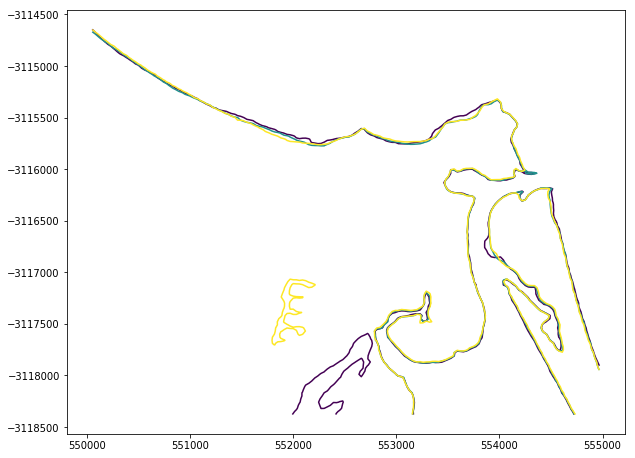

In [45]:
# Prepare attributes as input to contour extract
attribute_data = {'timeperiod': composite_ds.timeperiod.values.tolist()}  
attribute_dtypes = {'timeperiod': 'str'}

# Extract contours with custom attribute fields:
gdf = SpatialTools.contour_extract(z_values=[index_threshold],
                                   ds_array=composite_ds[water_index],
                                   ds_crs=composite_ds.crs,
                                   ds_affine=composite_ds.geobox.transform,
                                   output_shp=f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}.shp',
                                   min_vertices=min_vertices,  
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes,
                                   verbose=False,                                   
                                   dim='timeperiod')

# Plot contours
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, cmap='viridis')

Affine(30.0, 0.0, 550035.0,
       0.0, -30.0, -3113895.0)